### Building a Retrieval Model with Merlin Models
This notebook is created using the latest stable merlin-tensorflow container.

In large scale recommender systems pipelines, the size of the item catalog (number of unique items) might be in the order of millions. At such scale, a typical setup is having two-stage pipeline, where a faster candidate retrieval model quickly extracts thousands of relevant items and a then a more powerful ranking model (i.e. with more features and more powerful architecture) ranks the top-k items that are going to be displayed to the user. For ML-based candidate retrieval model, as it needs to quickly score millions of items for a given user, a popular choices are models that can produce recommendation scores by just computing the dot product the user embeddings and item embeddings. Popular choices of such models are Matrix Factorization, which learns low-rank user and item embeddings, and the Two-Tower architecture, which is a neural network with two MLP towers where both user and item features are fed to generate user and item embeddings in the output.

Dataset
In this notebook, we are building a Two-Tower model for Item Retrieval task using synthetic datasets that are mimicking the real Ali-CCP: Alibaba Click and Conversion Prediction dataset.

Learning objectives
Preparing the data with NVTabular
Training and evaluating Two-Tower model with Merlin Models
Exporting the model for deployment
Importing Libraries

In [18]:
import merlin.models.tf as mm
from merlin.io.dataset import Dataset

In [19]:
import os

from merlin.models.utils.example_utils import workflow_fit_transform

from merlin.schema.tags import Tags

import tensorflow as tf

In [20]:

import nvtabular as nvt
from nvtabular.ops import *

## Feature Engineering with NVTabular
Let's generate synthetic train and validation dataset objects.

In [21]:
from merlin.datasets.synthetic import generate_data

DATA_FOLDER = os.environ.get("DATA_FOLDER", "/workspace/data/")
NUM_ROWS = os.environ.get("NUM_ROWS", 10000)
SYNTHETIC_DATA = eval(os.environ.get("SYNTHETIC_DATA", "True"))

if SYNTHETIC_DATA:
    train, valid = generate_data("aliccp-raw", int(NUM_ROWS), set_sizes=(0.7, 0.3))
else:
    train = nvt.Dataset(DATA_FOLDER + "/train/*.parquet")
    valid = nvt.Dataset(DATA_FOLDER + "/valid/*.parquet")

In [22]:
# define output path for the processed parquet files
output_path = os.path.join(DATA_FOLDER, "processed")
output_path

'/workspace/data/processed'

In [23]:
import os
os.getcwd()

'C:\\Users\\Sushanth S\\Class Lectures\\Internshp_SFC\\models-main'

We keep only positive interactions where clicks==1 in the dataset with Filter() op.

In [24]:
category_temp_directory = os.path.join(DATA_FOLDER, "categories")
user_id = ["user_id"] >> Categorify(out_path=category_temp_directory) >> TagAsUserID()
item_id = ["item_id"] >> Categorify(out_path=category_temp_directory) >> TagAsItemID()

item_features = ["item_category", "item_shop", "item_brand"] >> Categorify(out_path=category_temp_directory) >> TagAsItemFeatures()

user_features = (
    [
        "user_shops",
        "user_profile",
        "user_group",
        "user_gender",
        "user_age",
        "user_consumption_2",
        "user_is_occupied",
        "user_geography",
        "user_intentions",
        "user_brands",
        "user_categories",
    ]
    >> Categorify(out_path=category_temp_directory)
    >> TagAsUserFeatures()
)

inputs = user_id + item_id + item_features + user_features + ["click"]

outputs = inputs >> Filter(f=lambda df: df["click"] == 1)

With transform_aliccp function, we can execute fit() and transform() on the raw dataset applying the operators defined in the NVTabular workflow pipeline above. The processed parquet files are saved to output_path.

In [25]:
from merlin.datasets.ecommerce import transform_aliccp

transform_aliccp((train, valid), output_path, nvt_workflow=outputs)

C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\schema\tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\io\dataset.py:256: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\schema\tags.py:148: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\schema\tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be r

Building a Two-Tower Model with Merlin Models
We will use Two-Tower Model for item retrieval task. Real-world large scale recommender systems have hundreds of millions of items (products) and users. Thus, these systems often composed of two stages: candidate generation (retrieval) and ranking (scoring the retrieved items). At candidate generation step, a subset of relevant items from large item corpus is retrieved. You can read more about two stage Recommender Systems here. In this example, we're going to focus on the retrieval stage.

A Two-Tower Model consists of item (candidate) and user (query) encoder towers. With two towers, the model can learn representations (embeddings) for queries and candidates separately.

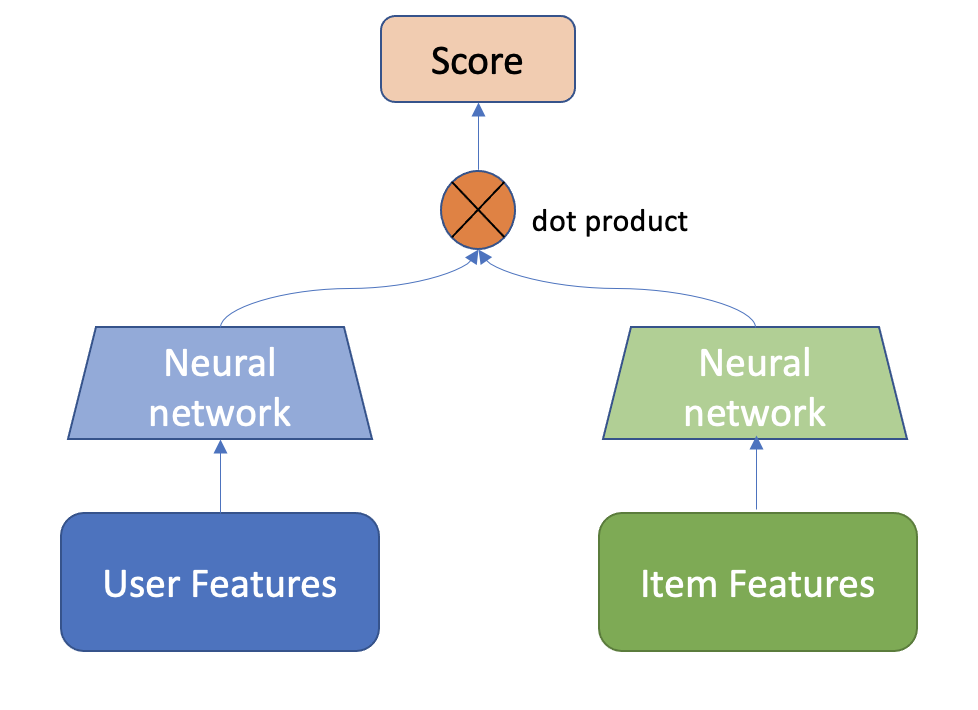

image Adapted from:(Off-policy Learning in Two-stage Recommender Systems) https://dl.acm.org/doi/abs/10.1145/3366423.3380130

We use the schema object to define our model.

In [129]:
output_path

'/workspace/data/processed'

In [130]:
train = Dataset(os.path.join(output_path, "train", "*.parquet"))
valid = Dataset(os.path.join(output_path, "valid", "*.parquet"))

C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\io\dataset.py:256: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Select features with user and item tags, and be sure to exclude target column.

In [131]:
schema = train.schema.select_by_tag([Tags.ITEM_ID, Tags.USER_ID, Tags.ITEM, Tags.USER])
train.schema = schema
valid.schema = schema

We can print out the feature column names.

In [132]:
schema.column_names

['user_id',
 'item_id',
 'item_category',
 'item_shop',
 'item_brand',
 'user_shops',
 'user_profile',
 'user_group',
 'user_gender',
 'user_age',
 'user_consumption_2',
 'user_is_occupied',
 'user_geography',
 'user_intentions',
 'user_brands',
 'user_categories']

We expect the label names to be empty.

In [133]:
label_names = schema.select_by_tag(Tags.TARGET).column_names
label_names

[]

###### Negative sampling
Many datasets for recommender systems contain implicit feedback with logs of user interactions like clicks, add-to-cart, purchases, music listening events, rather than explicit ratings that reflects user preferences over items. To be able to learn from implicit feedback, we use the general (and naive) assumption that the interacted items are more relevant for the user than the non-interacted ones. In Merlin Models we provide some scalable negative sampling algorithms for the Item Retrieval Task. In particular, we use in this example the in-batch sampling algorithm which uses the items interacted by other users as negatives within the same mini-batch.

**Building the Model**

    Now, let's build our Two-Tower model. In a nutshell, we aggregate all user features to feed in user tower and feed the item features to the item tower. Then we compute the positive score by multiplying the user embedding with the item embedding and sample negative items (read more about negative sampling here and here), whose item embeddings are also multiplied by the user embedding. Then we apply the loss function on top of the positive and negative scores.
    https://openreview.net/pdf?id=824xC-SgWgU
    https://medium.com/mlearning-ai/overview-negative-sampling-on-recommendation-systems-230a051c6cd7

In [134]:
model = mm.TwoTowerModel(
    schema,
    query_tower=mm.MLPBlock([128, 64], no_activation_last_layer=True),
    samplers=[mm.InBatchSampler()],
    embedding_options=mm.EmbeddingOptions(infer_embedding_sizes=True),
)

Let's explain the parameters in the TwoTowerModel():

1. no_activation_last_layer: when set True, no activation is used for top hidden layer. Learn more here.
2. infer_embedding_sizes: when set True, automatically defines the embedding dimension from the feature cardinality in the schema

**> Metrics:**

The following information retrieval metrics are used to compute the Top-10 accuracy of recommendation lists containing all items:

**Normalized Discounted Cumulative Gain (NDCG@10):** NDCG accounts for rank of the relevant item in the recommendation list and is a more fine-grained metric than HR, which only verifies whether the relevant item is among the top-k items.

**Recall@10:** Also known as HitRate@n when there is only one relevant item in the recommendation list. Recall just verifies whether the relevant item is among the top-n items.

We need to initialize the dataloaders.

In [135]:
model.compile(optimizer="adam", run_eagerly=False, metrics=[mm.RecallAt(10), mm.NDCGAt(10)])
model.fit(train, validation_data=valid, batch_size=4096, epochs=3)

C:\ProgramData\Anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - ETA: 0s - loss: 8.1570 - recall_at_10: 0.0053 - ndcg_at_10: 0.0033 - regularization_loss: 0.0000e+00 - loss_batch: 8.1277

2/2 [==============================] - 10s 1s/step - loss: 8.1570 - recall_at_10: 0.0057 - ndcg_at_10: 0.0035 - regularization_loss: 0.0000e+00 - loss_batch: 8.0702 - val_loss: 7.9885 - val_recall_at_10: 0.0070 - val_ndcg_at_10: 0.0039 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 7.9885
Epoch 2/3
2/2 [==============================] - 1s 458ms/step - loss: 8.1567 - recall_at_10: 0.0093 - ndcg_at_10: 0.0056 - regularization_loss: 0.0000e+00 - loss_batch: 8.0699 - val_loss: 7.9885 - val_recall_at_10: 0.0107 - val_ndcg_at_10: 0.0050 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 7.9885
Epoch 3/3
2/2 [==============================] - 1s 496ms/step - loss: 8.1563 - recall_at_10: 0.0145 - ndcg_at_10: 0.0092 - regularization_loss: 0.0000e+00 - loss_batch: 8.0695 - val_loss: 7.9885 - val_recall_at_10: 0.0180 - val_ndcg_at_10: 0.0087 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 7.9885


# Error Solution:

In [ ]:
from numpy.random import RandomState
np.random.randint(0, 2**32,dtype='int64')

In [ ]:
#inside dispatch.py line no 656 change made from original

In [ ]:
import numpy as np

In [ ]:
# Random states
def get_states(random_state, low, high, size):
    rs = np.random.RandomState(random_state)
    states = rs.randint(low=low, high=high, size=size)
    return states

# Call function
states = get_states(random_state=42, low=2, high=28347, size=25)

### Exporting Retrieval Models
So far we have trained and evaluated our Retrieval model. Now, the next step is to deploy our model and generate top-K recommendations given a user (query). We can efficiently serve our model by indexing the trained item embeddings into an Approximate Nearest Neighbors (ANN) engine. Basically, for a given user query vector, that is generated passing the user features into user tower of retrieval model, we do an ANN search query to find the ids of nearby item vectors, and at serve time, we score user embeddings over all indexed top-K item embeddings within the ANN engine.

In doing so, we need to export

1. user (query) tower
2. item and user features
3. item embeddings
>**Save User (query) tower**
We are able to save the user tower model as a TF model to disk. The user tower model is needed to generate a user embedding vector when a user feature vector x is fed into that model.

In [136]:
query_tower = model.retrieval_block.query_block()
query_tower.save(os.path.join(DATA_FOLDER, "query_tower"))

INFO:tensorflow:Assets written to: /workspace/data/query_tower\assets


INFO:tensorflow:Assets written to: /workspace/data/query_tower\assets


### Extract and save User features
With unique_rows_by_features utility function we can easily extract both unique user and item features tables as cuDF dataframes. Note that for user features table, we use USER and USER_ID tags.

In [137]:
from merlin.models.utils.dataset import unique_rows_by_features

user_features = (
    unique_rows_by_features(train, Tags.USER, Tags.USER_ID).compute().reset_index(drop=True)
)

C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\io\dataset.py:256: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [138]:
user_features.head()

,user_id,user_shops,user_profile,user_group,user_gender,user_age,user_consumption_2,user_is_occupied,user_geography,user_intentions,user_brands,user_categories
0,12,12,2,1,1,1,1,1,1,12,12,12
1,147,147,15,2,1,1,1,1,1,147,147,147
2,65,65,6,1,1,1,1,1,1,65,65,65
3,18,18,2,1,1,1,1,1,1,18,18,18
4,27,27,4,1,1,1,1,1,1,27,27,27


In [139]:
user_features.shape

(244, 12)

In [140]:
# save to disk
user_features.to_parquet(os.path.join(DATA_FOLDER, "user_features.parquet"))

### Extract and save Item features

In [141]:
item_features = (
    unique_rows_by_features(train, Tags.ITEM, Tags.ITEM_ID).compute().reset_index(drop=True)
)

C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\io\dataset.py:256: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [142]:
item_features.head()

,item_id,item_category,item_shop,item_brand
0,24,24,24,24
1,44,44,44,44
2,3,3,3,3
3,14,14,14,14
4,55,55,55,55


In [143]:
# save to disk
item_features.to_parquet(os.path.join(DATA_FOLDER, "item_features.parquet"))

## Extract and save Item embeddings

In [144]:
item_embs = model.item_embeddings(Dataset(item_features, schema=schema), batch_size=1024)
item_embs_df = item_embs.compute(scheduler="synchronous")

C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\io\dataset.py:256: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


INFO:tensorflow:Assets written to: C:\Users\SUSHAN~1\AppData\Local\Temp\tmpvk96pg3l\assets


INFO:tensorflow:Assets written to: C:\Users\SUSHAN~1\AppData\Local\Temp\tmpvk96pg3l\assets
C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\io\dataset.py:256: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\schema\tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\io\dataset.py:256: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [145]:
item_embs_df

,item_id,item_category,item_shop,item_brand,0,1,2,3,4,5,...,54,55,56,57,58,59,60,61,62,63
0,24,24,24,24,-0.012888,0.009055,-0.025922,-0.015115,0.062901,-0.011260,...,-0.022625,-0.036717,-0.085791,-0.012863,-0.024853,-0.001400,-0.039401,0.072047,-0.025377,0.018310
1,44,44,44,44,-0.014731,-0.024999,-0.031419,-0.003753,0.063261,-0.028368,...,-0.004610,-0.002892,-0.044402,-0.007952,0.008067,-0.028471,-0.017631,0.066092,0.004579,-0.037046
2,3,3,3,3,0.011768,-0.016261,-0.012817,0.005632,0.065218,0.027383,...,0.046264,-0.032614,-0.005159,0.018801,-0.012215,-0.012261,-0.049397,-0.042100,0.040520,0.008564
3,14,14,14,14,0.035868,-0.013477,0.006211,-0.015456,0.068264,0.021817,...,0.029014,-0.034274,-0.023193,0.016562,-0.004868,0.002371,-0.017949,0.010471,0.021373,-0.008561
4,55,55,55,55,0.041775,-0.014103,0.002613,-0.031636,0.039474,0.012734,...,-0.040387,-0.004852,0.049427,0.012824,0.028730,0.008218,-0.034498,0.012171,0.038680,-0.040525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,187,187,187,187,-0.030836,0.002151,-0.044478,-0.016550,0.054961,-0.019263,...,-0.012203,-0.016994,-0.041953,0.018262,-0.012628,-0.008772,-0.051687,0.026397,0.007453,0.020092
246,213,213,213,213,-0.026004,-0.009588,-0.042637,0.002774,0.049410,-0.015987,...,-0.003592,-0.004975,-0.052216,0.005384,-0.030052,-0.012004,-0.047306,0.009022,-0.005098,0.010022
247,215,215,215,215,0.009735,-0.023979,-0.011635,-0.018187,0.018776,-0.009580,...,-0.023086,-0.012602,0.025051,0.012493,0.003039,-0.009732,-0.005550,0.001786,0.033608,-0.018926
248,188,188,188,188,0.002937,0.003260,-0.022704,-0.017590,0.034912,0.000850,...,0.018118,-0.007686,-0.058207,0.002821,-0.016252,0.008872,-0.031774,0.023321,-0.010170,0.006971


In [146]:
# select only embedding columns
item_embeddings = item_embs_df.iloc[:, 4:]

In [147]:
item_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.012888,0.009055,-0.025922,-0.015115,0.062901,-0.011260,-0.005929,0.034844,-0.053957,0.006927,...,-0.022625,-0.036717,-0.085791,-0.012863,-0.024853,-0.001400,-0.039401,0.072047,-0.025377,0.018310
1,-0.014731,-0.024999,-0.031419,-0.003753,0.063261,-0.028368,-0.044784,0.053463,-0.064751,0.023340,...,-0.004610,-0.002892,-0.044402,-0.007952,0.008067,-0.028471,-0.017631,0.066092,0.004579,-0.037046
2,0.011768,-0.016261,-0.012817,0.005632,0.065218,0.027383,-0.001294,-0.033072,-0.014933,0.027854,...,0.046264,-0.032614,-0.005159,0.018801,-0.012215,-0.012261,-0.049397,-0.042100,0.040520,0.008564
3,0.035868,-0.013477,0.006211,-0.015456,0.068264,0.021817,-0.009076,-0.001802,-0.026894,-0.003130,...,0.029014,-0.034274,-0.023193,0.016562,-0.004868,0.002371,-0.017949,0.010471,0.021373,-0.008561
4,0.041775,-0.014103,0.002613,-0.031636,0.039474,0.012734,-0.008218,0.038010,-0.046995,-0.007597,...,-0.040387,-0.004852,0.049427,0.012824,0.028730,0.008218,-0.034498,0.012171,0.038680,-0.040525


In [148]:
# save to disk
item_embeddings.to_parquet(os.path.join(DATA_FOLDER, "item_embeddings.parquet"))

That's it. You have learned how to train and evaluate your Two-Tower retrieval model, and then how to export the required components to be able to deploy this model to generate recommendations. In order to learn more on serving a model to Triton Inference Server, please explore the examples in the Merlin and Merlin Systems repos.

https://github.com/triton-inference-server/server
https://github.com/NVIDIA-Merlin/Merlin
https://github.com/NVIDIA-Merlin/systems


# Model Evaluation

In [149]:
metrics = model.evaluate(valid, batch_size=1024, return_dict=True)
metrics

3/3 [==============================] - 0s 26ms/step - loss: 6.8904 - recall_at_10: 0.0236 - ndcg_at_10: 0.0151 - regularization_loss: 0.0000e+00 - loss_batch: 6.8774


{'loss': 6.890393257141113,
 'recall_at_10': 0.023000000044703484,
 'ndcg_at_10': 0.014021489769220352,
 'regularization_loss': 0.0,
 'loss_batch': 6.8419189453125}

In [151]:
model.predict(valid,batch_size=1024)

array([[ 0.01359068],
       [-0.00483242],
       [-0.00327853],
       ...,
       [ 0.01070507],
       [-0.00160859],
       [ 0.00153043]], dtype=float32)

In [155]:
valid.head()

,user_id,item_id,item_category,item_shop,item_brand,user_shops,user_profile,user_group,user_gender,user_age,user_consumption_2,user_is_occupied,user_geography,user_intentions,user_brands,user_categories,click
0,14,8,8,8,8,14,2,1,1,1,1,1,1,14,14,14,0
1,3,39,39,39,39,3,1,1,1,1,1,1,1,3,3,3,0
2,29,8,8,8,8,29,4,1,1,1,1,1,1,29,29,29,1
3,32,10,10,10,10,32,4,1,1,1,1,1,1,32,32,32,0
4,8,15,15,15,15,8,2,1,1,1,1,1,1,8,8,8,0


In [ ]:
#model.save(os.path.join(DATA_FOLDER, "custom_dlrm"))

# Exporting Ranking Models

This notebook is created using the latest stable merlin-tensorflow container.

In this example notebook we demonstrate how to export (save) NVTabular workflow and a ranking model for model deployment with Merlin Systems library.

Learning Objectives:

Export NVTabular workflow for model deployment
Export TensorFlow DLRM model for model deployment
We will follow the steps below:

Prepare the data with NVTabular and export NVTabular workflow
Train a DLRM model with Merlin Models and export the trained model

## Importing Libraries
Let's start with importing the libraries that we'll use in this notebook.

In [1]:
import os

import nvtabular as nvt
from nvtabular.ops import *

from merlin.models.utils.example_utils import workflow_fit_transform
from merlin.schema.tags import Tags

import merlin.models.tf as mm
from merlin.io.dataset import Dataset
import tensorflow as tf

After we execute fit() and transform() functions on the raw dataset applying the operators defined in the NVTabular workflow pipeline below, the processed parquet files are saved to output_path.

Feature Engineering with NVTabular
We use the synthetic train and test datasets generated by mimicking the real Ali-CCP: Alibaba Click and Conversion Prediction dataset to build our recommender system ranking models.

If you would like to use real Ali-CCP dataset instead, you can download the training and test datasets on tianchi.aliyun.com. You can then use get_aliccp() function to curate the raw csv files and save them as parquet files.

In [14]:
from merlin.datasets.synthetic import generate_data

DATA_FOLDER = os.environ.get("DATA_FOLDER", "workspace/data/")
NUM_ROWS = os.environ.get("NUM_ROWS", 10000)
SYNTHETIC_DATA = eval(os.environ.get("SYNTHETIC_DATA", "True"))
BATCH_SIZE = int(os.environ.get("BATCH_SIZE", 512))

if SYNTHETIC_DATA:
    train, valid = generate_data("aliccp-raw", int(NUM_ROWS), set_sizes=(0.7, 0.3))
    # save the datasets as parquet files
    train.to_ddf().to_parquet(os.path.join(DATA_FOLDER, "train"))
    valid.to_ddf().to_parquet(os.path.join(DATA_FOLDER, "valid"))

C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\schema\tags.py:148: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\schema\tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\io\dataset.py:256: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [15]:
train_path = os.path.join(DATA_FOLDER, "train", "*.parquet")
valid_path = os.path.join(DATA_FOLDER, "valid", "*.parquet")
output_path = os.path.join(DATA_FOLDER, "processed")

In [26]:
%%time
category_temp_directory = os.path.join(DATA_FOLDER, "categories")
user_id = ["user_id"] >> Categorify(out_path=category_temp_directory) >> TagAsUserID()
item_id = ["item_id"] >> Categorify(out_path=category_temp_directory) >> TagAsItemID()
targets = ["click"] >> AddMetadata(tags=[Tags.BINARY_CLASSIFICATION, "target"])

item_features = ["item_category", "item_shop", "item_brand"] >> Categorify(out_path=category_temp_directory) >> TagAsItemFeatures()

user_features = (
    [
        "user_shops",
        "user_profile",
        "user_group",
        "user_gender",
        "user_age",
        "user_consumption_2",
        "user_is_occupied",
        "user_geography",
        "user_intentions",
        "user_brands",
        "user_categories",
    ]
    >> Categorify(out_path=category_temp_directory)
    >> TagAsUserFeatures()
)

outputs = user_id + item_id + item_features + user_features + targets

workflow = nvt.Workflow(outputs)

train_dataset = nvt.Dataset(train_path)
valid_dataset = nvt.Dataset(valid_path)

workflow.fit(train_dataset)
workflow.transform(train_dataset).to_parquet(output_path=output_path + "/train/")
workflow.transform(valid_dataset).to_parquet(output_path=output_path + "/valid/")

C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\io\dataset.py:256: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\schema\tags.py:148: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\schema\tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


Wall time: 1.36 s


We save NVTabular workflow model in the current working directory.

In [27]:
workflow.save(os.path.join(DATA_FOLDER, "workflow"))

Let's check out our saved workflow model folder.

In [28]:
#!pip install seedir

In [29]:
import seedir as sd

sd.seedir(
    DATA_FOLDER,
    style="lines",
    itemlimit=10,
    depthlimit=3,
    exclude_folders=".ipynb_checkpoints",
    sort=True,
)

data/
├─categories/
│ └─categories/
│   ├─unique.item_brand.parquet
│   ├─unique.item_category.parquet
│   ├─unique.item_id.parquet
│   ├─unique.item_shop.parquet
│   ├─unique.user_age.parquet
│   ├─unique.user_brands.parquet
│   ├─unique.user_categories.parquet
│   ├─unique.user_consumption_2.parquet
│   ├─unique.user_gender.parquet
│   └─unique.user_geography.parquet
├─processed/
│ ├─train/
│ │ ├─_file_list.txt
│ │ ├─_metadata
│ │ ├─_metadata.json
│ │ ├─part_0.parquet
│ │ └─schema.pbtxt
│ ├─valid/
│ │ ├─_file_list.txt
│ │ ├─_metadata
│ │ ├─_metadata.json
│ │ ├─part_0.parquet
│ │ └─schema.pbtxt
│ └─workflow/
│   ├─categories/
│   ├─metadata.json
│   └─workflow.pkl
└─workflow/
  ├─categories/
  │ ├─unique.item_brand.parquet
  │ ├─unique.item_category.parquet
  │ ├─unique.item_id.parquet
  │ ├─unique.item_shop.parquet
  │ ├─unique.user_age.parquet
  │ ├─unique.user_brands.parquet
  │ ├─unique.user_categories.parquet
  │ ├─unique.user_consumption_2.parquet
  │ ├─unique.user_gender.parque

Build and Train a DLRM model
In this example, we build, train, and export a Deep Learning Recommendation Model (DLRM) architecture. To learn more about how to train different deep learning models, how easily transition from one model to another and the seamless integration between data preparation and model training visit 03-Exploring-different-models.ipynb notebook.

NVTabular workflow above exports a schema file, schema.pbtxt, of our processed dataset. To learn more about the schema object, schema file and tags, you can explore 02-Merlin-Models-and-NVTabular-integration.ipynb.

https://github.com/NVIDIA-Merlin/models/blob/7a1227d91fe574aeaec624508c52b670a0ad7862/examples/02-Merlin-Models-and-NVTabular-integration.ipynb

In [30]:
# define train and valid dataset objects
train = Dataset(os.path.join(output_path, "train", "*.parquet"))
valid = Dataset(os.path.join(output_path, "valid", "*.parquet"))

# define schema object
schema = train.schema

In [31]:
target_column = schema.select_by_tag(Tags.TARGET).column_names[0]
target_column

'click'

In [32]:
model = mm.DLRMModel(
    schema,
    embedding_dim=64,
    bottom_block=mm.MLPBlock([128, 64]),
    top_block=mm.MLPBlock([128, 64, 32]),
    prediction_tasks=mm.BinaryClassificationTask(target_column),
)

In [33]:
%%time

model.compile("adam", run_eagerly=False, metrics=[tf.keras.metrics.AUC()])
model.fit(train, validation_data=valid, batch_size=BATCH_SIZE)

14/14 [==============================] - 3s 60ms/step - loss: 0.6933 - auc_1: 0.4888 - regularization_loss: 0.0000e+00 - loss_batch: 0.6933 - val_loss: 0.6932 - val_auc_1: 0.5038 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 0.6932
Wall time: 3.61 s


## Save model
The last step of machine learning (ML)/deep learning (DL) pipeline is to deploy the ETL workflow and saved model into production. In the production setting, we want to transform the input data as done during training (ETL). We need to apply the same mean/std for continuous features and use the same categorical mapping to convert the categories to continuous integer before we use the DL model for a prediction. Therefore, we deploy the NVTabular workflow with the Tensorflow model as an ensemble model to Triton Inference using Merlin Systems library very easily. The ensemble model guarantees that the same transformation is applied to the raw inputs.

Let's save our DLRM model.
https://github.com/NVIDIA-Merlin/systems

In [34]:
model.save(os.path.join(DATA_FOLDER, "dlrm"))

INFO:tensorflow:Unsupported signature for serialization: ((PredictionOutput(predictions=TensorSpec(shape=(None, 1), dtype=tf.float32, name='outputs/predictions'), targets=TensorSpec(shape=(None, 1), dtype=tf.float32, name='outputs/targets'), positive_item_ids=None, label_relevant_counts=None, valid_negatives_mask=None, negative_item_ids=None, sample_weight=None), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x0000024776D73340>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((PredictionOutput(predictions=TensorSpec(shape=(None, 1), dtype=tf.float32, name='outputs/predictions'), targets=TensorSpec(shape=(None, 1), dtype=tf.float32, name='outputs/targets'), positive_item_ids=None, label_relevant_counts=None, valid_negatives_mask=None, negative_item_ids=None, sample_weight=None), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x0000024776D73340>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((PredictionOutput(predictions=TensorSpec(shape=(None, 1), dtype=tf.float32, name='outputs/predictions'), targets=TensorSpec(shape=(None, 1), dtype=tf.float32, name='outputs/targets'), positive_item_ids=None, label_relevant_counts=None, valid_negatives_mask=None, negative_item_ids=None, sample_weight=None), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x0000024776D73340>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((PredictionOutput(predictions=TensorSpec(shape=(None, 1), dtype=tf.float32, name='outputs/predictions'), targets=TensorSpec(shape=(None, 1), dtype=tf.float32, name='outputs/targets'), positive_item_ids=None, label_relevant_counts=None, valid_negatives_mask=None, negative_item_ids=None, sample_weight=None), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x0000024776D73340>), {}).


INFO:tensorflow:Assets written to: /workspace/data/dlrm\assets


INFO:tensorflow:Assets written to: /workspace/data/dlrm\assets


Deploying the model with Merlin Systems
We trained and exported our ranking model and NVTabular workflow. In the next step, we will learn how to deploy our trained DLRM model into Triton Inference Server with Merlin Systems library. NVIDIA Triton Inference Server (TIS) simplifies the deployment of AI models at scale in production. TIS provides a cloud and edge inferencing solution optimized for both CPUs and GPUs. It supports a number of different machine learning frameworks such as TensorFlow and PyTorch.

For the next step, visit Merlin Systems library and execute Serving-Ranking-Models-With-Merlin-Systems notebook to deploy our saved DLRM and NVTabular workflow models as an ensemble to TIS and obtain prediction results for a qiven request. In doing so, you need to mount the saved DLRM and NVTabular workflow to the inference container following the instructions in the README.md.
https://github.com/NVIDIA-Merlin/systems
https://github.com/triton-inference-server/server
https://github.com/NVIDIA-Merlin/systems/blob/main/examples/Serving-Ranking-Models-With-Merlin-Systems.ipynb


## Serving Ranking Models With Merlin Systems
This notebook is created using the latest stable merlin-tensorflow container. This Jupyter notebook example demonstrates how to deploy a ranking model to Triton Inference Server (TIS) and generate prediction results for a given query. As a prerequisite, the ranking model must be trained and saved with Merlin Models. Please read the README for the instructions.

Overview
NVIDIA Merlin is an open source framework that accelerates and scales end-to-end recommender system pipelines. The Merlin framework is broken up into several sub components, these include: Merlin-Core, Merlin-Models, NVTabular and Merlin-Systems. Merlin Systems will be the focus of this example.

The purpose of the Merlin Systems library is to make it easy for Merlin users to quickly deploy their recommender systems from development to Triton Inference Server. We extended the same user-friendly API users are accustomed to in NVTabular and leveraged it to accommodate deploying recommender system components to TIS.

There are some points we need ensure before we continue with this Notebook. Please ensure you have a working NVTabular workflow and model stored in an accessible location. Merlin Systems take the data preprocessing workflow defined in NVTabular and load that into Triton Inference Server as a model. Subsequently it does the same for the trained model. Lets take a closer look at how Merlin Systems makes deploying to TIS simple and effortless, in the rest of this notebook.

Learning objectives
In this notebook, we learn how to deploy a NVTabular Workflow and a trained Tensorflow model from Merlin Models to Triton.

Load NVTabular Workflow
Load Pre-trained Merlin Models model
Create Ensemble Graph
Export Ensemble Graph
Run Tritonserver
Send Request to Tritonserver
Dataset
We use the synthetic train and test datasets generated by mimicking the real Ali-CCP: Alibaba Click and Conversion Prediction dataset to build our recommender system ranking models. To see how the data is transformed with NVTabular and how a DLRM model is trained with Merlin Models check out the 04-Exporting-ranking-models.ipynb example notebook which is a prerequisite for this notebook.

It is important to note that the steps take in this notebook are generalized and can be applied to any set of workflow and models.

Tools
NVTabular
Merlin Models
Merlin Systems
Triton Inference Server
Install Required Libraries
Install TensorFlow so we can read the saved model from disk.

### Load an NVTabular Workflow
First, we load the nvtabular.Workflow that we created in with this example.

In [35]:
import os
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
from nvtabular.workflow import Workflow

input_path = os.environ.get("INPUT_FOLDER", "/workspace/data")

workflow_stored_path = os.path.join(input_path, "workflow")

workflow = Workflow.load(workflow_stored_path)

After we load the workflow, we remove the label columns from it's inputs. This removes all columns with the TARGET tag from the workflow. We do this because we need to set the workflow to only require the features needed to predict, not train, when creating an inference pipeline.

In [36]:
from merlin.schema.tags import Tags

label_columns = workflow.output_schema.select_by_tag(Tags.TARGET).column_names
workflow.remove_inputs(label_columns)

Load the Tensorflow Model
After loading the workflow, we load the model. This model was trained with the output of the workflow from the Exporting Ranking Models example from Merlin Models.

First, we need to import the Merlin Models library. Loading a TensorFlow model, which is based on custom subclasses, requires to the subclass definition. Otherwise, TensorFlow cannot load correctly load the model.

In [37]:
import merlin.models.tf as mm

In [38]:
import tensorflow as tf
input_path = os.environ.get("INPUT_FOLDER", "/workspace/data")
tf_model_path = os.path.join(input_path, "dlrm")

model = tf.keras.models.load_model(tf_model_path)

C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\schema\tags.py:148: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
C:\Users\Sushanth S\Class Lectures\Internshp_SFC\models-main\merlin\schema\tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


### Create the Ensemble Graph
After we have both the model and the workflow loaded, we can create the ensemble graph. You create the graph. The goal is to illustrate the path of data through your full system. In this example we only serve a workflow with a model, but you can add other components that help you meet your business logic requirements.

Because this example has two components—a model and a workflow—we require two operators. These operators, also known as inference operators, are meant to abstract away all the "hard parts" of loading a specific component, such as a workflow or model, into Triton Inference Server.

The following code block shows how to use two inference operators:

TransformWorkflow
This operator ensures that the workflow is correctly saved and packaged with the required config so the server will know how to load it.
PredictTensorflow
This operator will do something similar with the model, loaded before.
Let's give it a try.

In [39]:
#!pip install tritonclient

In [40]:
from merlin.systems.dag.ops.workflow import TransformWorkflow
from merlin.systems.dag.ops.tensorflow import PredictTensorflow

serving_operators = workflow.input_schema.column_names >> TransformWorkflow(workflow) >> PredictTensorflow(model)

### Export Graph as Ensemble
The last step is to create the ensemble artifacts that Triton Inference Server can consume. To make these artifacts, we import the Ensemble class. The class is responsible for interpreting the graph and exporting the correct files for the server.

After you run the following cell, you'll see that we create a ColumnSchema for the expected inputs to the workflow. The workflow is a Schema.

When you are creating an Ensemble object you supply the graph and a schema representing the starting input of the graph. the inputs to the ensemble graph are the inputs to the first operator of your graph.

After you have created the Ensemble you export the graph, supplying an export path for the Ensemble.export function.

This returns an ensemble config which represents the entire inference pipeline and a list of node-specific configs.

Let's take a look below.

In [50]:
workflow.output_schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension
0,user_id,"(Tags.ID, Tags.USER, Tags.USER_ID, Tags.CATEGO...",int64,False,False,None,0,0,0,/workspace/data/categories/categories/unique.u...,0,244,user_id,245,35
1,item_id,"(Tags.ID, Tags.ITEM, Tags.CATEGORICAL, Tags.IT...",int64,False,False,None,0,0,0,/workspace/data/categories/categories/unique.i...,0,250,item_id,251,35
2,item_category,"(Tags.ITEM, Tags.CATEGORICAL)",int64,False,False,None,0,0,0,/workspace/data/categories/categories/unique.i...,0,250,item_category,251,35
3,item_shop,"(Tags.ITEM, Tags.CATEGORICAL)",int64,False,False,None,0,0,0,/workspace/data/categories/categories/unique.i...,0,250,item_shop,251,35
4,item_brand,"(Tags.ITEM, Tags.CATEGORICAL)",int64,False,False,None,0,0,0,/workspace/data/categories/categories/unique.i...,0,250,item_brand,251,35
5,user_shops,"(Tags.USER, Tags.CATEGORICAL)",int64,False,False,None,0,0,0,/workspace/data/categories/categories/unique.u...,0,244,user_shops,245,35
6,user_profile,"(Tags.USER, Tags.CATEGORICAL)",int64,False,False,None,0,0,0,/workspace/data/categories/categories/unique.u...,0,48,user_profile,49,16
7,user_group,"(Tags.USER, Tags.CATEGORICAL)",int64,False,False,None,0,0,0,/workspace/data/categories/categories/unique.u...,0,10,user_group,11,16
8,user_gender,"(Tags.USER, Tags.CATEGORICAL)",int64,False,False,None,0,0,0,/workspace/data/categories/categories/unique.u...,0,2,user_gender,3,16
9,user_age,"(Tags.USER, Tags.CATEGORICAL)",int64,False,False,None,0,0,0,/workspace/data/categories/categories/unique.u...,0,6,user_age,7,16


In [128]:
from merlin.systems.dag.ensemble import Ensemble
import numpy as np

ensemble = Ensemble(serving_operators, workflow.input_schema)

export_path = os.path.join(input_path, "ensemble")

ens_conf, node_confs = ensemble.export(export_path)

AttributeError: 'SelectionOp' object has no attribute 'export_name'

In [122]:
export_path

'/workspace/data\\ensemble'

##### Retrieving Recommendations from Triton Inference Server
Now that our server is running, we can send requests to it. This request is composed of values that correspond to the request schema that was created when we exported the ensemble graph.

In the code below we create a request to send to triton and send it. We will then analyze the response, to show the full experience.

First we need to ensure that we have a client connected to the server that we started. To do this, we use the Triton HTTP client library.



In [113]:
import tritonclient.http as client

# Create a triton client
try:
    triton_client = client.InferenceServerClient(url="localhost:8000", verbose=True)
    print("client created.")
except Exception as e:
    print("channel creation failed: " + str(e))

client created.


In [114]:
# ensure triton is in a good state
#triton_client.is_server_live()
#triton_client.get_model_repository_index()

In [116]:
from merlin.core.dispatch import get_lib

df_lib = get_lib()

original_data_path = os.environ.get("INPUT_FOLDER", "/workspace/data/processed")

# read in data for request
batch = df_lib.read_parquet(
    os.path.join(original_data_path,"valid", "part.0.parquet"),columns=workflow.input_schema.column_names
)
batch

,user_id,item_id,item_category,item_shop,item_brand,user_shops,user_profile,user_group,user_gender,user_age,user_consumption_2,user_is_occupied,user_geography,user_intentions,user_brands,user_categories
0,14,8,8,8,8,14,2,1,1,1,1,1,1,14,14,14
1,3,39,39,39,39,3,1,1,1,1,1,1,1,3,3,3
2,29,8,8,8,8,29,4,1,1,1,1,1,1,29,29,29
3,32,10,10,10,10,32,4,1,1,1,1,1,1,32,32,32
4,8,15,15,15,15,8,2,1,1,1,1,1,1,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,6,43,43,43,43,6,1,1,1,1,1,1,1,6,6,6
2996,25,10,10,10,10,25,3,1,1,1,1,1,1,25,25,25
2997,39,49,49,49,49,39,5,1,1,1,1,1,1,39,39,39
2998,19,24,24,24,24,19,3,1,1,1,1,1,1,19,19,19


In [80]:
from merlin.systems.triton import convert_df_to_triton_input
import tritonclient.grpc as grpcclient
# create inputs and outputs

inputs = convert_df_to_triton_input(workflow.input_schema, batch, grpcclient.InferInput)
output_cols = ensemble.graph.output_schema.column_names
outputs = [
    grpcclient.InferRequestedOutput(col)
    for col in output_cols
]

In [112]:
outputs

## Retrieving Recommendations from Triton Inference Server
Now that our server is running, we can send requests to it. This request is composed of values that correspond to the request schema that was created when we exported the ensemble graph.

In the code below we create a request to send to triton and send it. We will then analyze the response, to show the full experience.

First we need to ensure that we have a client connected to the server that we started. To do this, we use the Triton HTTP client library.
https://github.com/triton-inference-server/server

In [94]:
import tritonclient.http as client

# Create a triton client
try:
    triton_client = client.InferenceServerClient(url="192.168.12.12:12345", verbose=True)
    print("client created.")
except Exception as e:
    print("channel creation failed: " + str(e))

client created.


In [88]:
#!pip install tritonclient[all]

In [99]:
# ensure triton is in a good state
#triton_client.is_server_live()
#triton_client.get_model_repository_index()

In [123]:
from merlin.systems.triton import convert_df_to_triton_input
import tritonclient.grpc as grpcclient
# create inputs and outputs

inputs = convert_df_to_triton_input(workflow.input_schema, batch, grpcclient.InferInput)

output_cols = ensemble.graph.output_schema.column_names

outputs = [
    grpcclient.InferRequestedOutput(col)
    for col in output_cols
]

In [124]:
cols = ensemble.graph.output_schema.column_names

In [125]:
for i in cols:
    print(i)

click/binary_classification_task
